# Support Vector Machine

### Load the data first

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing, svm
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import sklearn.model_selection as model_selection
import pickle
#File Path
training_folder = 'training_data/'


# instantiate empty arrays for features and labels
Xtr = np.array([])
ytr = np.array([])
k = 0 # initialize

# load data from the relevant files
while True:
    try:
        # load data file
        class_k = np.loadtxt(training_folder + 'Class{:}.csv'.format(k))
        # extract features and labels
        class_k_features = class_k[:,:-1] # extract features
        class_k_labels  = class_k[:,-1].astype(np.int) # labels; convert to int
        # append the features and labels to the arrays
        Xtr = np.vstack([Xtr,class_k_features]) if Xtr.size else class_k_features
        ytr = np.hstack([ytr,class_k_labels]) if ytr.size else class_k_labels
        # increment counter
        k += 1
    except:
        print('loaded %i classes of training data' %k)
        break

# examine shape
num_classes = k
num_features = Xtr.shape[1]
num_samples = Xtr.shape[0]



print('unique labels: ', np.unique(ytr))
print('number of features: ', num_features)
print('number of samples: ', num_samples)

loaded 20 classes of training data
unique labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
number of features:  20
number of samples:  100000


### Standardize the Data and Split Data

In [2]:
#Get the mean and standard deviation of the training data
Xtr_mean = Xtr.mean(axis=0)
Xtr_std = Xtr.std(axis=0)

#Standardize the training data
Xtr_scale = (Xtr - Xtr_mean) / Xtr_std

#Split the data into testing and training sets with a 20/80 split
x_train,x_test,y_train,y_test = model_selection.train_test_split(Xtr_scale, ytr, test_size = 0.2, shuffle = True)
print('Scale for default gamma:', 1 / (x_train.shape[1] * x_train.var()))

Scale for default gamma: 0.04994683690395945


### Joint Training

In [3]:
#Initialize Classifier
svm_multi_joint = svm.SVC(kernel = "rbf", C=1, gamma= 'scale', decision_function_shape='ovo')



#Setting Confision Matrix and accuracy matrix
C_joint = np.zeros((20,20))
acc_joint =  []


#fit the data
svm_multi_joint.fit(x_train, y_train)
yhat_temp = svm_multi_joint.predict(x_test)


#Measure performance and add confusion matrix
acc_joint.append(accuracy_score(yhat_temp,y_test))
C_joint = (confusion_matrix(y_test, yhat_temp))

acc_joint_mean = np.mean(acc_joint)


print("Mean Accuracy:{}%".format(acc_joint_mean*100))
#print(np.array_str(C_joint, precision=4, suppress_small=True))


Mean Accuracy:89.21%


Drawing Confusion Matrix

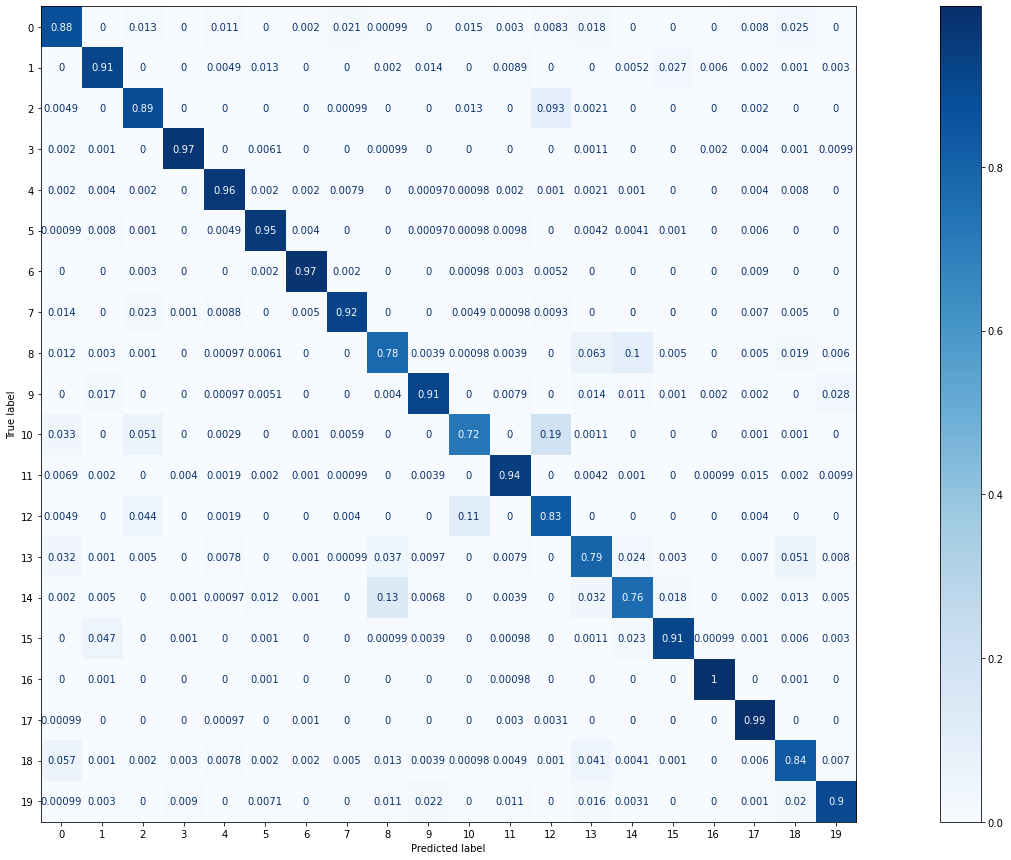

In [4]:
C_joint = C_joint/np.sum(C_joint,axis=1)
plt.rcParams['figure.figsize'] = [30, 15]
cmp = ConfusionMatrixDisplay(C_joint)
cmp.plot(cmap=plt.cm.Blues)

### One Versus Rest 

In [5]:
#Initialize Classifier
svm_multi_ovsr = svm.SVC(kernel = "rbf", C=1, gamma='scale', decision_function_shape='ovr')



#Setting Confision Matrix and accuracy matrix
C_ovsr = np.zeros((20,20))
acc_ovsr =  []


#Training

#fit the data
svm_multi_ovsr.fit(x_train, y_train)
yhat_temp = svm_multi_ovsr.predict(x_test)
    
#Measure performance and add confusion matrix
acc_ovsr.append(accuracy_score(yhat_temp,y_test))
C_ovsr = (confusion_matrix(y_test, yhat_temp))

acc_ovsr_mean = np.mean(acc_ovsr)


print("Mean Accuracy:{}%".format(acc_joint_mean*100))

Mean Accuracy:89.21%


Drawing Confusion Matrix

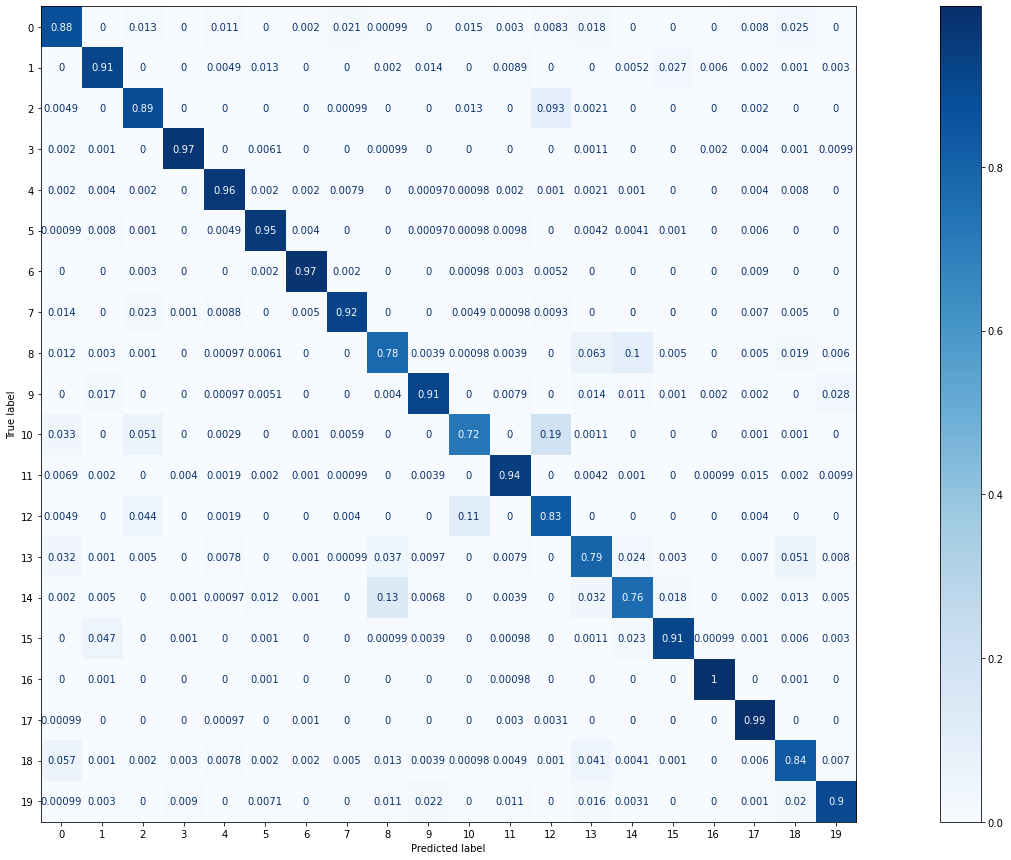

In [6]:
C_ovsr = C_ovsr/np.sum(C_ovsr,axis=1)
plt.rcParams['figure.figsize'] = [30, 15]
cmp = ConfusionMatrixDisplay(C_ovsr)
cmp.plot(cmap=plt.cm.Blues)

### Optimizing gamma and C via Cross-Validation (Joint Training)

In [11]:
#Setting parameters
C_test = [0.1,1,10]
gam_test = [0.005,0.05,0.5]



nC = len(C_test)
ngam = len(gam_test)
acc = np.zeros((nC,ngam))


for i , c in enumerate(C_test):
    for j, ga in enumerate(gam_test ):
                
        #setup classifier and fitting
        svm_temp= svm.SVC(kernel = "rbf", C=c, gamma=ga, decision_function_shape='ovo')
        svm_temp.fit(x_train, y_train)
        yhat_temp = svm_temp.predict(x_test)
                
        #Measure accuracy
        acc[i,j] = accuracy_score(yhat_temp,y_test)


        

In [12]:
print(np.array_str(acc, suppress_small=True))

[[0.7835  0.87005 0.52125]
 [0.8677  0.89475 0.79845]
 [0.8885  0.901   0.79835]]


In [21]:
Opt_c_gamma = np.argwhere(acc==np.max(acc))

0.901


Train with optimal parameters

In [4]:
#Initialize Classifier
svm_joint_opt = svm.SVC(kernel = "rbf", C=10, gamma= 0.05, decision_function_shape='ovo')



#Setting Confision Matrix and accuracy matrix
C_joint_opt = np.zeros((20,20))
acc_opt =  []


#fit the data
svm_joint_opt.fit(x_train, y_train)
yhat_temp = svm_joint_opt.predict(x_test)


#Measure performance and add confusion matrix
acc_opt.append(accuracy_score(yhat_temp,y_test))
C_joint_opt = (confusion_matrix(y_test, yhat_temp))

acc_joint_mean = np.mean(acc_opt)

# save the model to disk
filename = 'SVM_model.sav'
pickle.dump(svm_joint_opt, open(filename, 'wb'))

print("Mean Accuracy:{}%".format(acc_joint_mean*100))
#print(np.array_str(C_joint, precision=4, suppress_small=True))


Mean Accuracy:89.765%


Text(0, 0.5, 'Ture Label')

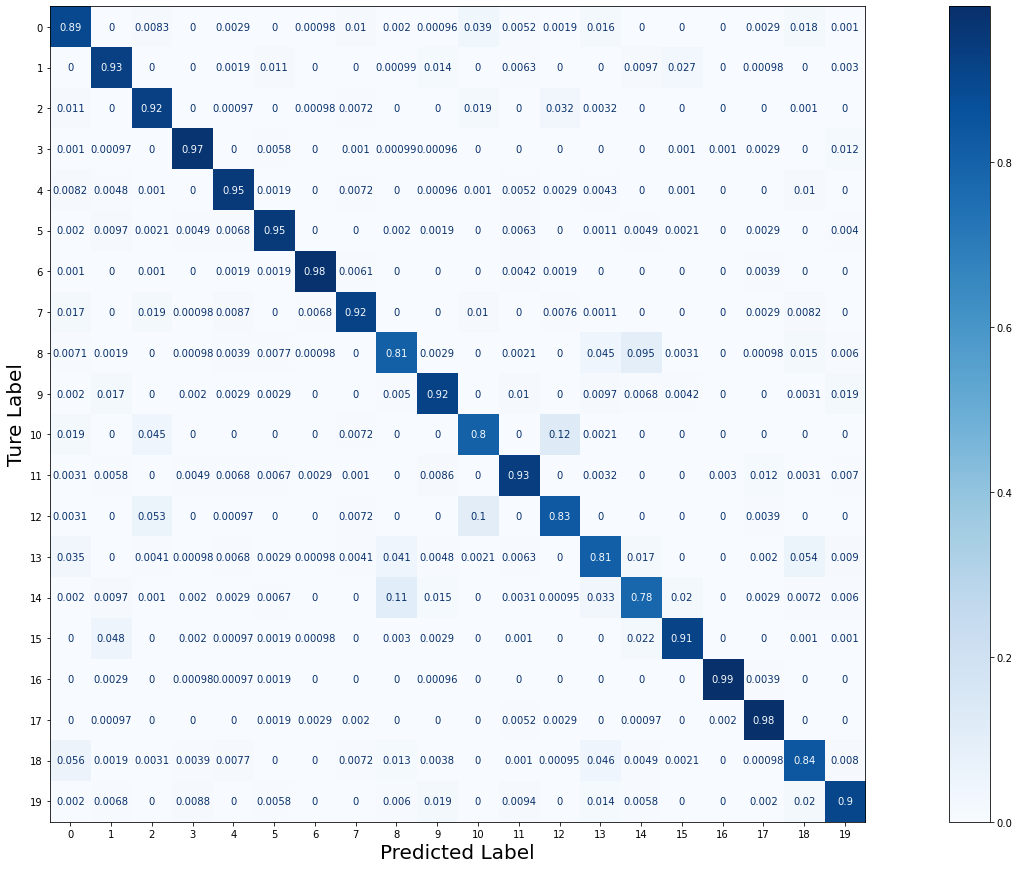

In [31]:
C_joint_opt= C_joint_opt/np.sum(C_joint_opt,axis=1)
plt.rcParams['figure.figsize'] = [30, 15]
cmp = ConfusionMatrixDisplay(C_joint_opt)
cmp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted Label',size =20)
plt.ylabel('Ture Label',size =20)

### Over all Training


In [29]:
#Initialize Classifier
svc_joint_overall = svm.SVC(kernel = "rbf", C=C_test[Opt_c_gamma[0][0]], gamma= gam_test[Opt_c_gamma[0][1]], decision_function_shape='ovo')

#Setting Confision Matrix and accuracy matrix
C_joint_overall = np.zeros((20,20))
acc_joint_overall =  []


#fit the data
svc_joint_overall.fit(Xtr_scale, ytr)
yhat_temp = svc_joint_overall.predict(Xtr_scale)
    
#Measure performance and add confusion matrix
acc_joint_overall.append(accuracy_score(yhat_temp,ytr))
C_joint_overall = (confusion_matrix(ytr, yhat_temp))

acc_joint_mean = np.mean(acc_joint_overall)


print("Mean Accuracy:{}%".format(acc_joint_mean*100))

Mean Accuracy:92.67999999999999%


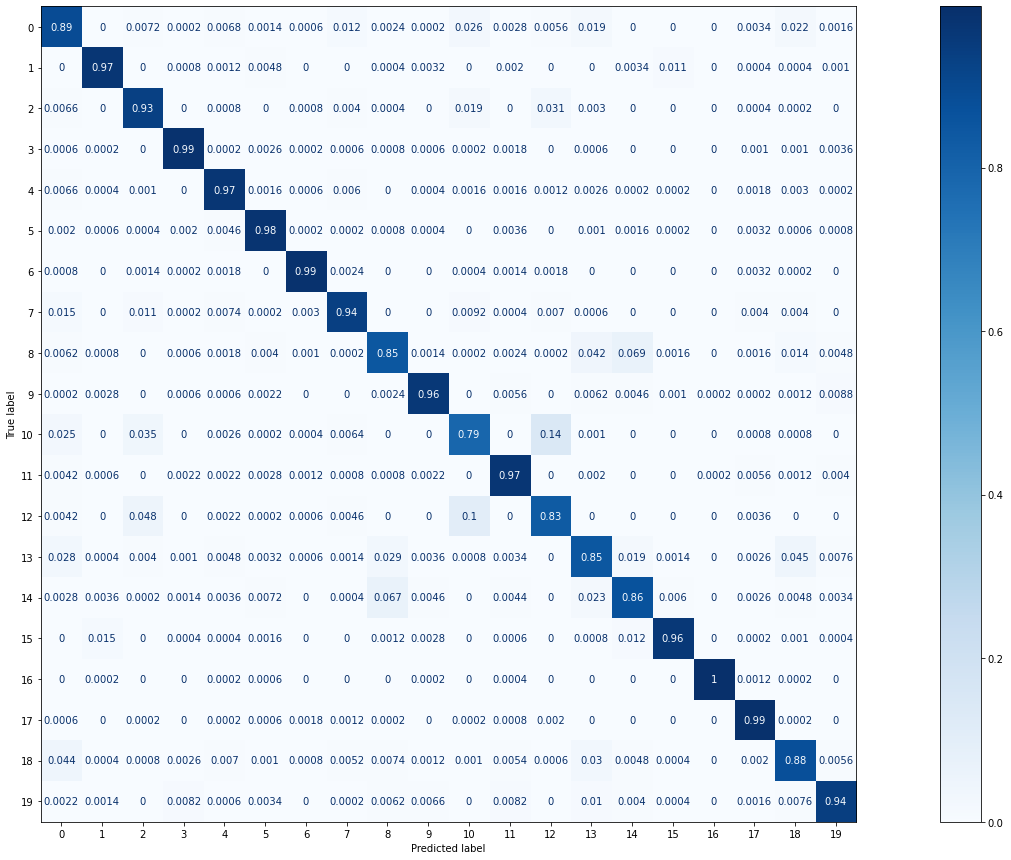

In [30]:
C_joint_overall = C_joint_overall/np.sum(C_joint_overall,axis=1)
plt.rcParams['figure.figsize'] = [30, 15]
cmp = ConfusionMatrixDisplay(C_joint_overall)
cmp.plot(cmap=plt.cm.Blues)